# First go <br>
at looking at some data statistics and how the different datasets relate to one another

In [72]:
# Imports
%matplotlib inline
import pandas as pd
import gzip
import matplotlib.pyplot as plt

In [13]:
# Set pandas to display all columns
pd.set_option('display.max_columns', None)

In [14]:
books_50k = pd.read_json('../raw_data/goodreads_books.json.gz',
                          lines=True,
                          compression='gzip',
                          nrows=50_000)

# Analysis description <br>
All columns are object type, so number ones need to be converted. <br>
We may select languages that are eng or '' (as those are Eng too, it seems) <br>
We may want to make individual columns for popular shelves (such as 'to-read count') <br>

In [15]:
books_50k.dtypes
# Convert to numeric columns
num_cols = [
    'text_reviews_count',
    'average_rating',
    'num_pages',
    'ratings_count'
]
books_50k[num_cols] = books_50k[num_cols].apply(
    lambda x: pd.to_numeric(x, errors='coerce')
)

In [16]:
# check country code columns
display(books_50k[books_50k['country_code'] == ''].shape)
# assign blank country code as NA
books_50k['country_code'] = books_50k['country_code'].apply(
    lambda x: pd.NA if x == '' else x
)

(8, 29)

In [22]:
# check language column
# Show count for all languages
pd.set_option('display.max_rows', None)
display(books_50k['language_code'].value_counts().sort_values())
pd.reset_option('display.max_rows')

# keep only eng lang books
eng_lang = ['eng', 'en-US', 'en-GB', 'en-CA', '']
books_50k = books_50k[books_50k['language_code'].isin(eng_lang)]


language_code
dum          1
pra          1
lat          1
ota          1
arw          1
enm          1
aze          1
fao          1
crh          1
gla          1
glg          1
mus          2
tgl          2
sqi          2
grc          2
pt-BR        2
es-MX        2
kan          2
mya          2
wel          2
mkd          3
hye          3
guj          3
--           3
en           3
nno          3
kur          4
tel          4
nep          5
bos          5
mon          5
mar          6
isl          6
mul          6
fil          7
kor          8
nob          8
mal          8
afr          8
tam         13
slv         14
urd         15
kat         16
pes         18
cat         19
hin         19
heb         20
ukr         23
slo         38
lav         41
lit         41
est         42
zho         42
hun         43
srp         54
tha         54
nor         60
scr         63
ben         66
vie         74
rum        100
dan        110
msa        127
pol        133
rus        135
bul        

In [23]:
# Check similar books column
books_50k.similar_books.apply(lambda x: len(x)).sort_values()

# check num pages column
books_50k.num_pages.value_counts().sort_index()
display(books_50k['num_pages'].quantile([0.25, 0.5, 0.75, 0.9, 0.99, 1]))

# remove the massive book as outlier
books_50k

0.25       144.0
0.50       245.0
0.75       336.0
0.90       435.0
0.99       812.0
1.00    945077.0
Name: num_pages, dtype: float64

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,similar_books,description,format,link,authors,publisher,num_pages,publication_day,isbn13,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
0,0312853122,1.0,[],US,,"[{'count': '3', 'name': 'to-read'}, {'count': ...",,false,4.00,,[],,Paperback,https://www.goodreads.com/book/show/5333265-w-...,"[{'author_id': '604031', 'role': ''}]",St. Martin's Press,256.0,1,9780312853129,9,,1984,https://www.goodreads.com/book/show/5333265-w-...,https://images.gr-assets.com/books/1310220028m...,5333265,3.0,5400751,W.C. Fields: A Life on Film,W.C. Fields: A Life on Film
1,0743509986,6.0,[],US,,"[{'count': '2634', 'name': 'to-read'}, {'count...",,false,3.23,B000FC0PBC,"[8709549, 17074050, 28937, 158816, 228563, 112...","Anita Diamant's international bestseller ""The ...",Audio CD,https://www.goodreads.com/book/show/1333909.Go...,"[{'author_id': '626222', 'role': ''}]",Simon & Schuster Audio,NaN,1,9780743509985,10,Abridged,2001,https://www.goodreads.com/book/show/1333909.Go...,https://s.gr-assets.com/assets/nophoto/book/11...,1333909,10.0,1323437,Good Harbor,Good Harbor
2,,7.0,[189911],US,eng,"[{'count': '58', 'name': 'to-read'}, {'count':...",B00071IKUY,false,4.03,,"[19997, 828466, 1569323, 425389, 1176674, 2627...",Omnibus book club edition containing the Ladie...,Hardcover,https://www.goodreads.com/book/show/7327624-th...,"[{'author_id': '10333', 'role': ''}]","Nelson Doubleday, Inc.",600.0,,,,Book Club Edition,1987,https://www.goodreads.com/book/show/7327624-th...,https://images.gr-assets.com/books/1304100136m...,7327624,140.0,8948723,"The Unschooled Wizard (Sun Wolf and Starhawk, ...","The Unschooled Wizard (Sun Wolf and Starhawk, ..."
3,0743294297,3282.0,[],US,eng,"[{'count': '7615', 'name': 'to-read'}, {'count...",,false,3.49,B002ENBLOK,"[6604176, 6054190, 2285777, 82641, 7569453, 70...",Addie Downs and Valerie Adler were eight when ...,Hardcover,https://www.goodreads.com/book/show/6066819-be...,"[{'author_id': '9212', 'role': ''}]",Atria Books,368.0,14,9780743294294,7,,2009,https://www.goodreads.com/book/show/6066819-be...,https://s.gr-assets.com/assets/nophoto/book/11...,6066819,51184.0,6243154,Best Friends Forever,Best Friends Forever
4,0850308712,5.0,[],US,,"[{'count': '32', 'name': 'to-read'}, {'count':...",,false,3.40,,[],,,https://www.goodreads.com/book/show/287140.Run...,"[{'author_id': '149918', 'role': ''}]",,NaN,,9780850308716,,,,https://www.goodreads.com/book/show/287140.Run...,https://images.gr-assets.com/books/1413219371m...,287140,15.0,278577,Runic Astrology: Starcraft and Timekeeping in ...,Runic Astrology: Starcraft and Timekeeping in ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49992,1542910188,1.0,[],US,,[],,false,5.00,B06X6GFWXJ,[],Complex Three...in the heart of the Republic's...,Paperback,https://www.goodreads.com/book/show/34300575-c...,"[{'author_id': '6942150', 'role': ''}]",Createspace Independent Publishing Platform,NaN,6,9781542910187,2,,2017,https://www.goodreads.com/book/show/34300575-c...,https://images.gr-assets.com/books/1487166076m...,34300575,1.0,55354290,Complex Three,Complex Three
49994,,2.0,[],US,,"[{'count': '25', 'name': 'to-read'}, {'count':...",B00XS47ASA,true,4.53,B0175P4BRK,[],The craft of home cheesemaking is exploding in...,,https://www.goodreads.com/book/show/25561514-m...,"[{'author_id': '3455913', 'role': ''}]",,NaN,,,,,,https://www.goodreads.com/book/show/25561514-m...,https://s.gr-assets.com/assets/nophoto/book/11...,25561514,8.0,45358569,Mastering Basic Cheesemaking: The Fun and Fund...,Mastering Basic Cheesemaking: The Fun and Fund...
49997,148472741X,3.0,[],US,,"[{'count': '17', 'name': 'to-read'}, {'count':...",,false,4.31,B009OIZ9M8,[],Join in the festivities of the season as Mike ...,Hardcover,https://www.goodreads.com/

In [24]:

# describe
books_50k[num_cols].describe()


,text_reviews_count,average_rating,num_pages,ratings_count
count,40956.000000,40956.000000,25919.000000,40956.000000
mean,35.701265,3.887848,292.650025,492.058282
std,386.415484,0.522771,5871.581166,7050.420417
min,0.000000,0.000000,0.000000,0.000000
25%,2.000000,3.650000,144.000000,6.000000
50%,4.000000,3.920000,245.000000,23.000000
75%,14.000000,4.170000,336.000000,93.000000
max,38878.000000,5.000000,945077.000000,575163.000000


In [25]:
# check max values for num cols
books_50k[books_50k['num_pages'] == 945077.000000]

,isbn,text_reviews_count,series,country_code,language_code,popular_shelves,asin,is_ebook,average_rating,kindle_asin,similar_books,description,format,link,authors,publisher,num_pages,publication_day,isbn13,publication_month,edition_information,publication_year,url,image_url,book_id,ratings_count,work_id,title,title_without_series
18037,,30.0,[],US,eng,"[{'count': '46530', 'name': 'currently-reading...",B003ODIZL6,true,3.97,,"[6183819, 12728698, 8294444, 874941, 130068, 2...","""Oxford's American editors drew on its 200-mil...",Kindle Edition,https://www.goodreads.com/book/show/18684543-t...,"[{'author_id': '14392', 'role': 'Editor'}]",Oxford University Press Inc.,945077.0,,,,2nd Edition,2008,https://www.goodreads.com/book/show/18684543-t...,https://images.gr-assets.com/books/1382015770m...,18684543,378.0,762000,The New Oxford American Dictionary,The New Oxford American Dictionary


<Axes: ylabel='Frequency'>

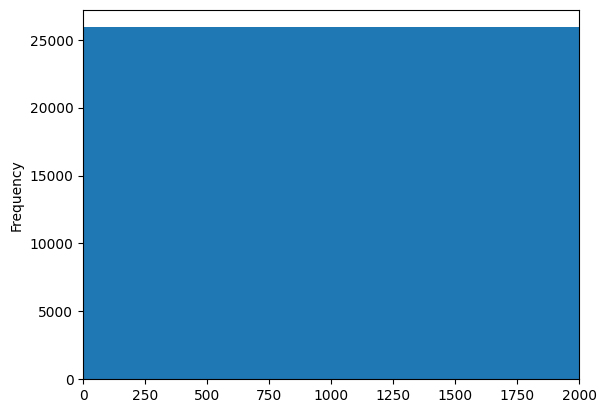

In [ ]:
# fig, ax = plt.subplots(2, 2, figsize=(10,6))
# ax[0, 0].hist(books_50k['num_pages'], bins=20)
# ax[0, 0].set_xlim(0, 2000)
num_cols
books_50k.num_pages.plot(kind='hist', xlim=(0, 2000))

In [27]:
books_50k['num_pages'].quantile([0.5, 0.9, 0.99, 0.999])

0.500     245.00
0.900     435.00
0.990     812.00
0.999    1878.56
Name: num_pages, dtype: float64

In [28]:
books_50k.info()

<class 'pandas.core.frame.DataFrame'>
Index: 40964 entries, 0 to 49999
Data columns (total 29 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   isbn                  40964 non-null  object 
 1   text_reviews_count    40956 non-null  float64
 2   series                40964 non-null  object 
 3   country_code          40956 non-null  object 
 4   language_code         40964 non-null  object 
 5   popular_shelves       40964 non-null  object 
 6   asin                  40964 non-null  object 
 7   is_ebook              40964 non-null  object 
 8   average_rating        40956 non-null  float64
 9   kindle_asin           40964 non-null  object 
 10  similar_books         40964 non-null  object 
 11  description           40964 non-null  object 
 12  format                40964 non-null  object 
 13  link                  40964 non-null  object 
 14  authors               40964 non-null  object 
 15  publisher             40

In [30]:
books_50k.country_code.unique()

array(['US', <NA>], dtype=object)

In [ ]:
# for dummy model, keep only some columns
books_50k.columns.tolist()
books_50k_small = books_50k[['isbn',
                             'text_reviews_count',
                             'average_rating',
                             'publication_year',
                             'ratings_count']]  # No num pages as it has many missing.

books_50k_small.dropna(how='all', inplace=True)

/var/folders/6s/v193bdc16850v6kfnm2_q0tw0000gn/T/ipykernel_84576/757337865.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  books_50k_small.dropna(how='all', inplace=True)


In [52]:
books_50k_small

,isbn,text_reviews_count,average_rating,publication_year,ratings_count
0,0312853122,1.0,4.00,1984,3.0
1,0743509986,6.0,3.23,2001,10.0
2,,7.0,4.03,1987,140.0
3,0743294297,3282.0,3.49,2009,51184.0
4,0850308712,5.0,3.40,,15.0
...,...,...,...,...,...
49992,1542910188,1.0,5.00,2017,1.0
49994,,2.0,4.53,,8.0
49997,148472741X,3.0,4.31,2016,13.0
49998,0099740516,36.0,3.95,1997,190.0


# Uploading data to BigQuery - Ended up using CLI instead <p>


In [7]:
from google.cloud import bigquery

In [ ]:
# Specify files to upload
books_graph = 'raw_data/goodreads_books.json.gz'

In [8]:
project = 'the-book-thrift'
dataset = 'goodreads_MentingWan'
table = 'books_graph'

table_name = f'{project}.{dataset}.{table}'

In [10]:
client = bigquery.Client()
write_mode = 'WRITE_TRUNCATE'
job_config = bigquery.LoadJobConfig(write_disposition=write_mode)

In [ ]:
job = client.load_table_from_json()

# Dummy Model with User interaction data

In [54]:
# load user interaction data
interactions = pd.read_csv('../raw_data/goodreads_interactions.csv', nrows=10_000)

In [57]:
interactions.describe()

,user_id,book_id,is_read,rating,is_reviewed
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000
mean,6.037100,4571.588900,0.294000,1.167200,0.05060
std,3.768547,3023.265107,0.455615,1.927905,0.21919
min,0.000000,0.000000,0.000000,0.000000,0.00000
25%,5.000000,2002.750000,0.000000,0.000000,0.00000
50%,5.000000,4432.500000,0.000000,0.000000,0.00000
75%,7.000000,6637.250000,1.000000,3.000000,0.00000
max,14.000000,12710.000000,1.000000,5.000000,1.00000


In [108]:
# Distribution of is-read status, rating, and is-reviews status
percent_read = interactions[interactions['is_read'] == 1].shape[0]/interactions.shape[0] * 100
percent_reviews = interactions[interactions['is_reviewed'] == 1].shape[0]/interactions.shape[0] * 100
print(f'{percent_read}% of interactions included reading the book')
print(f'{percent_reviews}% of interactions included reviewing the book')

29.4% of interactions included reading the book
5.06% of interactions included reviewing the book
